In [1]:
!mamba env create --quiet -f environment.yml

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK

done
Installing pip dependencies: ...working... done


In [ ]:
!conda env create --quiet -f https://raw.githubusercontent.com/Denolle-Lab/seisbench-jupyter/main/environment.yml

In [2]:
import obspy
import obsplus
import pandas as pd
from obspy.clients.fdsn import Client
from datetime import timedelta
import datetime
import matplotlib.pyplot as plt
import numpy as np
import logging
import requests
import seisbench
import seisbench.models as sbm
import dask
import json
import alaska_utils

# Progress bar for dask operations:
from dask.diagnostics import ProgressBar
pbar = dask.diagnostics.ProgressBar()
pbar.register()

ModuleNotFoundError: No module named 'obspy'

## 1. Download waveforms

In [3]:
# Load master station list
dfS = pd.read_parquet('https://github.com/zoekrauss/alaska_catalog/raw/main/data_acquisition/alaska_stations.parquet')

# Convert to pandas datetime
dfS['start_date']=pd.to_datetime(dfS['start_date'],infer_datetime_format=True,errors='coerce')
dfS['end_date']=pd.to_datetime(dfS['end_date'],infer_datetime_format=True,errors='coerce')

In [4]:
# Download waveforms

step = 60
t1 = datetime.datetime(2018,5,25,12,35)
t1 = datetime.datetime(2019,5,27,9,52,30)
t2 = t1 + pd.Timedelta(3,'minutes')
time_bins = pd.to_datetime(np.arange(t1,t2,pd.Timedelta(step,'seconds')))

@dask.delayed
def loop_times(dfS,t1,step):
    return alaska_utils.retrieve_waveforms(dfS,t1,t1+pd.Timedelta(step,'seconds'),separate=True)

lazy_results = [loop_times(dfS,time,step) for time in time_bins]

In [5]:
results = dask.compute(lazy_results)

[########################################] | 100% Completed | 48.3s
[########################################] | 100% Completed | 48.3s


In [6]:
# Concat into big list of streams
test = sum(results,[])
stream = []
for t in test:
    stream.extend(t)

## 2. Denoise

In [7]:
%%time
model = sbm.DeepDenoiser.from_pretrained("original")

CPU times: user 38 ms, sys: 2.45 ms, total: 40.5 ms
Wall time: 33.9 ms


In [8]:
%%time
denoise = np.empty([len(stream)],dtype=object)
for i,st in enumerate(stream):
    den = model.annotate(st)
    denoise[i]=den

CPU times: user 56 s, sys: 3.52 s, total: 59.5 s
Wall time: 19.1 s


## 3. Phase pick

In [9]:
model = sbm.EQTransformer.from_pretrained("original")

# EDIT MODEL TO NOT CUT SAMPLES OFF 
# the blinding is applied here: https://github.com/seisbench/seisbench/blob/c8c260854143e8241219ec25d9436188a7af124c/seisbench/models/eqtransformer.py#L215

# Note: can we avoid cutting off that last sample too?
model.default_args["blinding"] = (0,1)

In [10]:
%%time
annotation = np.empty([len(denoise)],dtype=object)
pick = np.empty([len(denoise)],dtype=object)
detection = np.empty([len(denoise)],dtype=object)
for i,st in enumerate(denoise):
    at = model.annotate(st)
    # pks, dets = model.classify(st)
    annotation[i]=at; # pick[i]=pks; detection[i]=dets;
    
# Note: still need to figure out why this error is thrown, but it is thrown here:
# https://github.com/seisbench/seisbench/blob/c8c260854143e8241219ec25d9436188a7af124c/seisbench/models/base.py#L623
# and here:
# https://github.com/seisbench/seisbench/blob/c8c260854143e8241219ec25d9436188a7af124c/seisbench/models/base.py#L548

2022-02-07 18:20:52,239 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples. Output might be empty.
2022-02-07 18:21:00,226 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples. Output might be empty.


CPU times: user 1min 32s, sys: 313 ms, total: 1min 33s
Wall time: 23.6 s


In [ ]:
# stride = argdict.get("stride", 1)
# Assume stride is 1?
#starts = np.arange(0, block.shape[1] - self.in_samples + 1, stride)

# Sooooo in_samples is less than block.shape[1]-1?

Notes about the "Parts of the input stream consist of fragments shorter than the number of input samples. Output might be empty" warning:

For t1 = datetime.datetime(2019,5,27,9,52,30), the warning is thrown on XO.LT12, though only on the first two minutes.
For t1 = datetime.datetime(2018,5,25,12,35), for the first minute, the warning is thrown on XO.LA32. For the next two minutes, it is thrown on XO.LA29.

I caught these by printing out the IDs of the traces for the raw data and the annotated data and visually comparing to see which one is missing- see below. Which is odd... since when you loop through the traces individually and print out their IDs to see which one the error is thrown on, the error is either thrown before or after the missing trace, which makes me think that there's an indexing problem.

It doesn't seem to have anything to do with overlap. The reason those overlaps were appearing was only because we had merged the streams together using this loop:
stream = obspy.core.stream.Stream()
for st in results[0]:
    stream.extend(st)
If you look at the stream produced by this loop, many stations have overlaps between the 60 s traces. It is not what is causing the issue.
The individual streams that the model.annotate() function is performed on do not have overlaps. This can be checked using stream.print_gaps()

I cannot for the life of me find anything that is different about the traces that the warning is thrown on... to be continued! I need to dig into the source code more.


In [68]:
ids = []
for stt in annotation:
    if stt:
        ids.append(stt[0].id[0:7])
ids.sort()
print(ids)

['AV.KAPH', 'AV.KAPH', 'AV.KAPH', 'AV.KCG.', 'AV.KCG.', 'AV.KCG.', 'TA.Q16K', 'TA.Q16K', 'TA.Q16K', 'TA.R17L', 'TA.R17L', 'TA.R17L', 'XO.EP15', 'XO.EP15', 'XO.EP15', 'XO.EP21', 'XO.EP21', 'XO.EP21', 'XO.EP22', 'XO.EP22', 'XO.EP22', 'XO.ET17', 'XO.ET17', 'XO.ET17', 'XO.ET18', 'XO.ET18', 'XO.ET18', 'XO.ET19', 'XO.ET19', 'XO.ET19', 'XO.ET20', 'XO.ET20', 'XO.ET20', 'XO.KD00', 'XO.KD00', 'XO.KD00', 'XO.KD02', 'XO.KD02', 'XO.KD02', 'XO.KD04', 'XO.KD04', 'XO.KD04', 'XO.KD05', 'XO.KD05', 'XO.KD05', 'XO.KD12', 'XO.KD12', 'XO.KD12', 'XO.KS03', 'XO.KS03', 'XO.KS03', 'XO.KS03', 'XO.KS03', 'XO.KS03', 'XO.KS11', 'XO.KS11', 'XO.KS11', 'XO.KS11', 'XO.KS11', 'XO.KS11', 'XO.KS13', 'XO.KS13', 'XO.KS13', 'XO.KS13', 'XO.KS13', 'XO.KS13', 'XO.KT06', 'XO.KT06', 'XO.KT06', 'XO.KT07', 'XO.KT07', 'XO.KT07', 'XO.KT08', 'XO.KT08', 'XO.KT08', 'XO.KT09', 'XO.KT09', 'XO.KT09', 'XO.LA21', 'XO.LA21', 'XO.LA21', 'XO.LA23', 'XO.LA23', 'XO.LA23', 'XO.LA25', 'XO.LA25', 'XO.LA25', 'XO.LA26', 'XO.LA26', 'XO.LA26', 'XO.LA28'

In [69]:
ids = []
for stt in stream:
    ids.append(stt[0].id[0:7])
ids.sort()
print(ids)

['AV.KAPH', 'AV.KAPH', 'AV.KAPH', 'AV.KCG.', 'AV.KCG.', 'AV.KCG.', 'TA.Q16K', 'TA.Q16K', 'TA.Q16K', 'TA.R17L', 'TA.R17L', 'TA.R17L', 'XO.EP15', 'XO.EP15', 'XO.EP15', 'XO.EP21', 'XO.EP21', 'XO.EP21', 'XO.EP22', 'XO.EP22', 'XO.EP22', 'XO.ET17', 'XO.ET17', 'XO.ET17', 'XO.ET18', 'XO.ET18', 'XO.ET18', 'XO.ET19', 'XO.ET19', 'XO.ET19', 'XO.ET20', 'XO.ET20', 'XO.ET20', 'XO.KD00', 'XO.KD00', 'XO.KD00', 'XO.KD02', 'XO.KD02', 'XO.KD02', 'XO.KD04', 'XO.KD04', 'XO.KD04', 'XO.KD05', 'XO.KD05', 'XO.KD05', 'XO.KD12', 'XO.KD12', 'XO.KD12', 'XO.KS03', 'XO.KS03', 'XO.KS03', 'XO.KS03', 'XO.KS03', 'XO.KS03', 'XO.KS11', 'XO.KS11', 'XO.KS11', 'XO.KS11', 'XO.KS11', 'XO.KS11', 'XO.KS13', 'XO.KS13', 'XO.KS13', 'XO.KS13', 'XO.KS13', 'XO.KS13', 'XO.KT06', 'XO.KT06', 'XO.KT06', 'XO.KT07', 'XO.KT07', 'XO.KT07', 'XO.KT08', 'XO.KT08', 'XO.KT08', 'XO.KT09', 'XO.KT09', 'XO.KT09', 'XO.LA21', 'XO.LA21', 'XO.LA21', 'XO.LA23', 'XO.LA23', 'XO.LA23', 'XO.LA25', 'XO.LA25', 'XO.LA25', 'XO.LA26', 'XO.LA26', 'XO.LA26', 'XO.LA28'

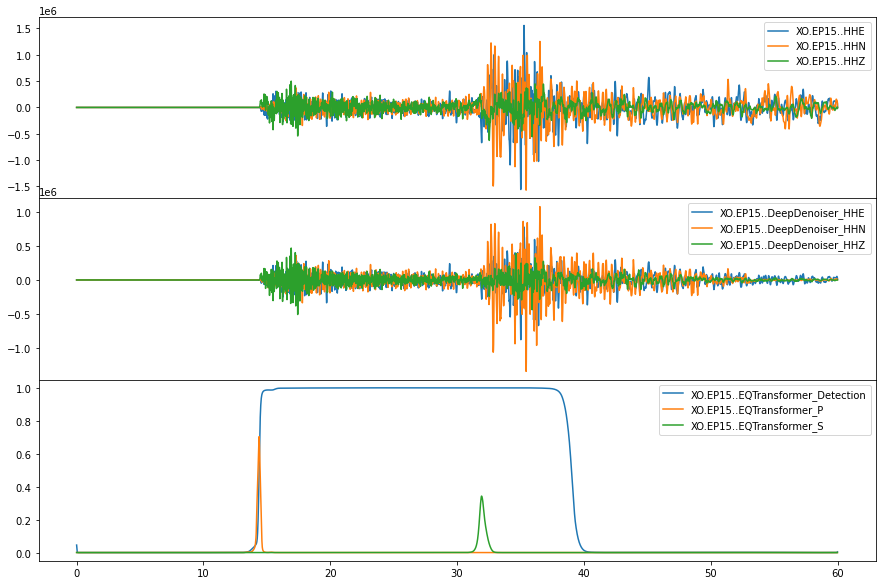

In [164]:
# GUT CHECK

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={'hspace': 0})

offset = annotation[0][0].stats.starttime - denoise[0][0].stats.starttime
i=5 # 5, 50
for j in [0,1,2]:
    axs[0].plot(stream[i][j].times(), stream[i][j].data, label=stream[i][j].id) 
    axs[1].plot(denoise[i][j].times(), denoise[i][j].data, label=denoise[i][j].id)
    axs[2].plot(annotation[i][j].times() + offset, annotation[i][j].data, label=annotation[i][j].id)

axs[0].legend()
axs[1].legend()
axs[2].legend()

## 4. Extract and save picks

Note: some annotated streams are 5999 samples, others are 6000

### Need to do some more checking on the amplitudes to make sure they don't need normalization- and also check that the denoising streams don't need normalization

In [163]:
import postprocess

preds = np.empty([1,6000,1,3])
dat = np.empty([1,6000,1,3])
station_ids = []
t0 = []
match_idx = []
for i in range(int(len(annotation))):
    
    # For empty annotations:
    if not annotation[i]:
        continue
    
    # For short traces:
    if annotation[i][0].stats.npts < preds.shape[1]:
        preds[0,:,0,0] = np.append(annotation[i][0].data,[0])
        preds[0,:,0,1] = np.append(annotation[i][1].data,[0])
        preds[0,:,0,2] = np.append(annotation[i][2].data,[0])
    # For traces of correct length:
    else:
        preds[0,:,0,0] = annotation[i][0].data
        preds[0,:,0,1] = annotation[i][1].data
        preds[0,:,0,2] = annotation[i][2].data
    
    station_id = annotation[i][0].stats.network + '..' + annotation[i][0].stats.station + '.'
    final_id = stream[i][0].stats.network + '.' + stream[i][0].stats.station + '..' + stream[i][0].stats.channel[0:2]
    station_ids.append(station_id)
    t0.append(str(annotation[i][0].stats.starttime))
    
    
    picks = postprocess.extract_picks(preds,station_ids = [station_id],fnames = [station_id],t0=[str(annotation[i][0].stats.starttime)])
    
    # TO-DO: now call to original data using the same i index to get amplitudes
    
    dat[0,:,0,0] = stream[i].select(channel="**Z")[0].data[0:6000]
    if stream[i].select(channel="**N"):
        dat[0,:,0,1] = stream[i].select(channel="**N")[0].data[0:6000]
        dat[0,:,0,2] = stream[i].select(channel="**E")[0].data[0:6000]
    else:
        dat[0,:,0,1] = stream[i].select(channel="**1")[0].data[0:6000]
        dat[0,:,0,2] = stream[i].select(channel="**2")[0].data[0:6000]
    amps = postprocess.extract_amplitude(dat,picks)

    # Then, if the pick isn't empty, make a GAMMA-style pick dictionary and save that!
    if picks[0].p_prob[0]:
        for j in range(len(picks[0].p_prob[0])):
            # Get timestamp of pick:
            ts = annotation[i][0].stats.starttime + (pd.Timedelta(1,'seconds')*annotation[i][0].stats.delta*picks[0].p_idx[0][j])
            # Save all info in dictionary:
            pdict = {'id':final_id,'timestamp':ts,'prob':picks[0].p_prob[0][j],'amp':amps[0].p_amp[0][j],'type':'P'}
            gamma_picks.append(pdict)
    if picks[0].s_prob[0]:
        for j in range(len(picks[0].s_prob[0])):
            # Get timestamp of pick:
            ts = annotation[i][0].stats.starttime + (pd.Timedelta(1,'seconds')*annotation[i][0].stats.delta*picks[0].s_idx[0][j])
            # Save all info in dictionary:
            sdict = {'id':final_id,'timestamp':ts,'prob':picks[0].s_prob[0][j],'amp':amps[0].s_amp[0][j],'type':'S'}
            gamma_picks.append(sdict)
    
        